# Statistics and Figures for Analysis by LFMC Range

## Initialisation

In [1]:
import json
import numpy as np
import os
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend import Legend

import initialise
import common
from analysis_utils import calc_statistics
from display_utils import display_frames

In [2]:
MIN_LFMC = 50
FIRE_RISK_THRESHOLD = 120
BIN_SIZE = 5

WITHIN_SITE_RMSE = 20.87
OUT_OF_SITE_RMSE = 25.36
WITHIN_SITE_R2 = 0.70
OUT_OF_SITE_R2 = 0.54

TICK_SIZE = 7
LEGEND_SIZE = 7
FONT_SIZE = 8
TITLE_SIZE = 10
MARKER_SIZE = 5

In [3]:
model = common.ANALYSIS_MODEL
ensemble_size = common.ENSEMBLE_SIZE
ensemble_runs = common.ENSEMBLE_RUNS

## Get the Samples and Predictions

In [4]:
SCENARIOS = ['within-site', 'out-of-site']
DISPLAY_NAMES = [' '.join([s.capitalize(), 'Models']) for s in SCENARIOS]
samples_file = os.path.join(common.DATASETS_DIR, 'samples_365days.csv')
model_dir1 = os.path.join(common.MODELS_DIR, f'{SCENARIOS[0]}_models')
model_dir2 = os.path.join(common.MODELS_DIR, f'{SCENARIOS[1]}_models')
output_dir = common.FIGURES_DIR

In [5]:
with open(os.path.join(model_dir1, 'model_params.json'), 'r') as f:
    ws_params = json.load(f)
samples2 = pd.read_csv(samples_file, index_col=0)
predict2 = pd.read_csv(os.path.join(model_dir2, f'ensemble{ensemble_size}_{model}.csv'), index_col=0).reindex(samples2.index)

predict1 = pd.read_csv(os.path.join(model_dir1, f'ensemble{ensemble_size}_{model}.csv'), index_col=0)
samples1 = samples2.reindex(predict1.index)

samples1 = samples1[ws_params['targetColumn']]
samples2 = samples2[ws_params['targetColumn']]

## Functions

### Statistical Functions

In [6]:
def rmse(errors):
    return np.sqrt((errors ** 2).mean())

In [7]:
def mae(errors):
    return errors.abs().mean()

In [8]:
def iqr_lower(errors):
    return errors.quantile(0.25)

In [9]:
def iqr_upper(errors):
    return errors.quantile(0.75)

In [10]:
def gen_stats(y, yhat, width=1, clip=True, lower=0, upper=300):
    data = pd.DataFrame({'y': y, 'yhat': yhat})
    data['LFMC_group'] = ((data.y / width).round() * width)
    if clip:
        data['LFMC_group'] = data['LFMC_group'].clip(lower, upper)
    data['Pred_error'] = data.yhat - data.y
    stats_ = data.groupby(['LFMC_group']).Pred_error.agg(['mean', 'std', 'count', rmse, mae, iqr_lower, iqr_upper])
    plot_range = range(lower, upper+1, width)
    return stats_.reindex(plot_range)   

In [11]:
def gen_means(y, yhat, width=1, clip=True, lower=0, upper=300):
    stats_ = []
    for _, pred in yhat.iteritems():
        stats_.append(gen_stats(y, pred, width=width, clip=clip, lower=lower, upper=upper))
    return pd.concat(stats_).groupby('LFMC_group').mean() #.convert_dtypes()

In [12]:
def gen_counts(y, width=1, clip=True, lower=0, upper=300):
    data = pd.DataFrame({'count': y, 'LFMC_group': ((y / width).round() * width)})
    if clip:
        data['LFMC_group'] = data['LFMC_group'].clip(lower, upper)
    data = data.groupby(['LFMC_group']).count()
    data = data.reindex(range(lower, upper+1, width))
    return data

### Plotting Functions

In [13]:
def plot_by_range(stats_plot, ax, xrange=[0, 300], xfocus=[0, 300], width=1, yrange=[-100, 100], yfocus=20, clip=True):
    plot_range = range(xrange[0], xrange[1]+1, width)
    ax.plot(stats_plot['mean'], label='Bias', color=sns.color_palette('tab20')[0])
    l1, = ax.plot(stats_plot.loc[:xfocus[0], 'rmse'], color=sns.color_palette('tab20')[3], linestyle='--')
    l2, = ax.plot(stats_plot.loc[xfocus[0]:xfocus[1], 'rmse'], color=sns.color_palette('tab20')[2])
    ax.plot(stats_plot.loc[xfocus[1]:, 'rmse'], color=sns.color_palette('tab20')[3], linestyle='--')
    ax.fill_between(
        plot_range,
        stats_plot['mean'] - stats_plot['std'],  #stats_plot['iqr_lower'],
        stats_plot['mean'] + stats_plot['std'],  #stats_plot['iqr_upper'],
        color=sns.color_palette('tab20')[1],
        alpha=0.5
    )
    ax.plot([xrange[0], xrange[1]], [yfocus, yfocus], ':', color=(0.5, 0.5, 0.5), linewidth=1)
    ax.text(xrange[1]-1, yfocus, f'RMSE={yfocus}%', va='bottom', ha='right', fontsize=7)
    negative = stats_plot['mean'][stats_plot['mean'].lt(0)]
    ax.plot([negative.index[0], negative.index[0]], [yrange[0], negative.iloc[0]], ':', color=(0.5, 0.5, 0.5), linewidth=1)
    temp_text = f'Models switch from\noverestimating to\nunderestimating at\nLFMC={negative.index[0]}%'
    ax.text(negative.index[0]+2, (yrange[0] - negative.iloc[0]) / 2, temp_text, va='top', ha='left', fontsize=7)
    handles, labels_ = ax.get_legend_handles_labels()
    ax.legend(handles + [(l1, l2)], labels_ + ['RMSE'], loc='lower left', fontsize=LEGEND_SIZE,
              handlelength=2.0, handler_map={tuple: HandlerTuple(ndivide=None)})
    ax.set_ylabel('Estimation error (%)', fontsize=FONT_SIZE)
    ax.set_xlabel('Measured LFMC (%)', fontsize=FONT_SIZE)
    ax.tick_params(labelsize=TICK_SIZE)
    ax.axis([xrange[0], xrange[1], yrange[0], yrange[1]])
    return ax

In [14]:
def samples_by_range(stats_plot, ax, lower=0, upper=300, width=1, clip=True, xlabel_start=0, xlabel_freq=10):
    plot_range = range(lower, upper+1, width)
    ax.bar(np.arange(stats_plot.index.shape[0]), list(stats_plot['count']), color=sns.color_palette('tab20')[0])
    ax.set_xticks(range(xlabel_start, stats_plot.index.shape[0]+1, xlabel_freq))
    ax.tick_params(labelsize=TICK_SIZE)
    ax.set_xticklabels([stats_plot.index[i] for i in range(xlabel_start, stats_plot.index.shape[0], xlabel_freq)])
    ax.set_ylabel('#Test Samples', fontsize=FONT_SIZE)
    ax.set_xlabel('Measured LFMC (%)', fontsize=FONT_SIZE)
    ax.set_xlim(ax.patches[0].get_x(), ax.patches[-1].get_x()+1)
    return ax

In [15]:
def gen_scatterplot(x, y, ax, xlabels, ylabels, threshold):
    style = y < threshold
    markers = {True: "D", False: "P"}
    ax = sns.regplot(x=np.log10(x), y=np.log10(y), ci=None, scatter=None, color="grey", ax=ax)
    ax = sns.scatterplot(x=np.log10(x), y=np.log10(y), hue=style, style=style, markers=markers, ax=ax)
    ax.set_xticks(np.log10(xlabels))
    ax.set_xticklabels(xlabels)
    ax.set_yticks(np.log10(ylabels))
    ax.set_yticklabels(ylabels)
    ax.tick_params(labelsize=TICK_SIZE)
    ax.set_xlabel('Sample Size (Log scale)', fontsize=FONT_SIZE)
    ax.set_ylabel('RMSE (%, Log scale)', fontsize=FONT_SIZE)
    handles, labels_ = ax.get_legend_handles_labels()
    ax.legend(handles, [f'$RMSE \geq {threshold}$%', f'$RMSE < {threshold}$%'], fontsize=LEGEND_SIZE)
    return ax

## Measured and Estimated LFMC - Summary Statistics

In [16]:
pd.DataFrame.from_records(
    [samples1.describe(), predict1.describe().mean(axis=1), samples2.describe(), predict2.describe().mean(axis=1)],
    index=pd.MultiIndex.from_arrays([
        [SCENARIOS[0], SCENARIOS[0], SCENARIOS[1], SCENARIOS[1]],
        ['Measured', 'Predicted', 'Measured', 'Predicted']])).round(1)

count   mean   std   min   25%    50%    75%    max
within-site Measured   20579.0  108.3  37.8   1.0  84.7  102.5  125.2  434.5
            Predicted  20579.0  108.5  31.6  35.7  88.9  104.3  123.6  298.8
out-of-site Measured   66946.0  109.1  37.2   1.0  85.5  102.8  125.0  477.0
            Predicted  66946.0  109.6  27.6  48.4  91.8  106.7  123.9  263.6

## LFMC by Range Figure

### Generate Data Frames

In [17]:
xrange = [30, 250]
df1 = gen_means(samples1, predict1, BIN_SIZE, True, xrange[0], xrange[1])
df2 = gen_means(samples2, predict2, BIN_SIZE, True, xrange[0], xrange[1])
df3 = gen_counts(samples1, BIN_SIZE, True, xrange[0], xrange[1])
df4 = gen_counts(samples2, BIN_SIZE, True, xrange[0], xrange[1])

threshold = 20
min_size = 5
xlabels = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]
ylabels = [10, 20, 50, 100, 200]
df5 = gen_means(samples1, predict1, width=1, lower=0, upper=500).dropna()
df6 = gen_means(samples2, predict2, width=1, lower=0, upper=500).dropna()
rmse_df = pd.concat([df6['count'], df5.rmse, df6.rmse], axis=1)
rmse_df.columns=['Count', 'Year-RMSE', 'Site-RMSE']
rmse_df = rmse_df[rmse_df['Count'].ge(min_size)]

### Plot Charts

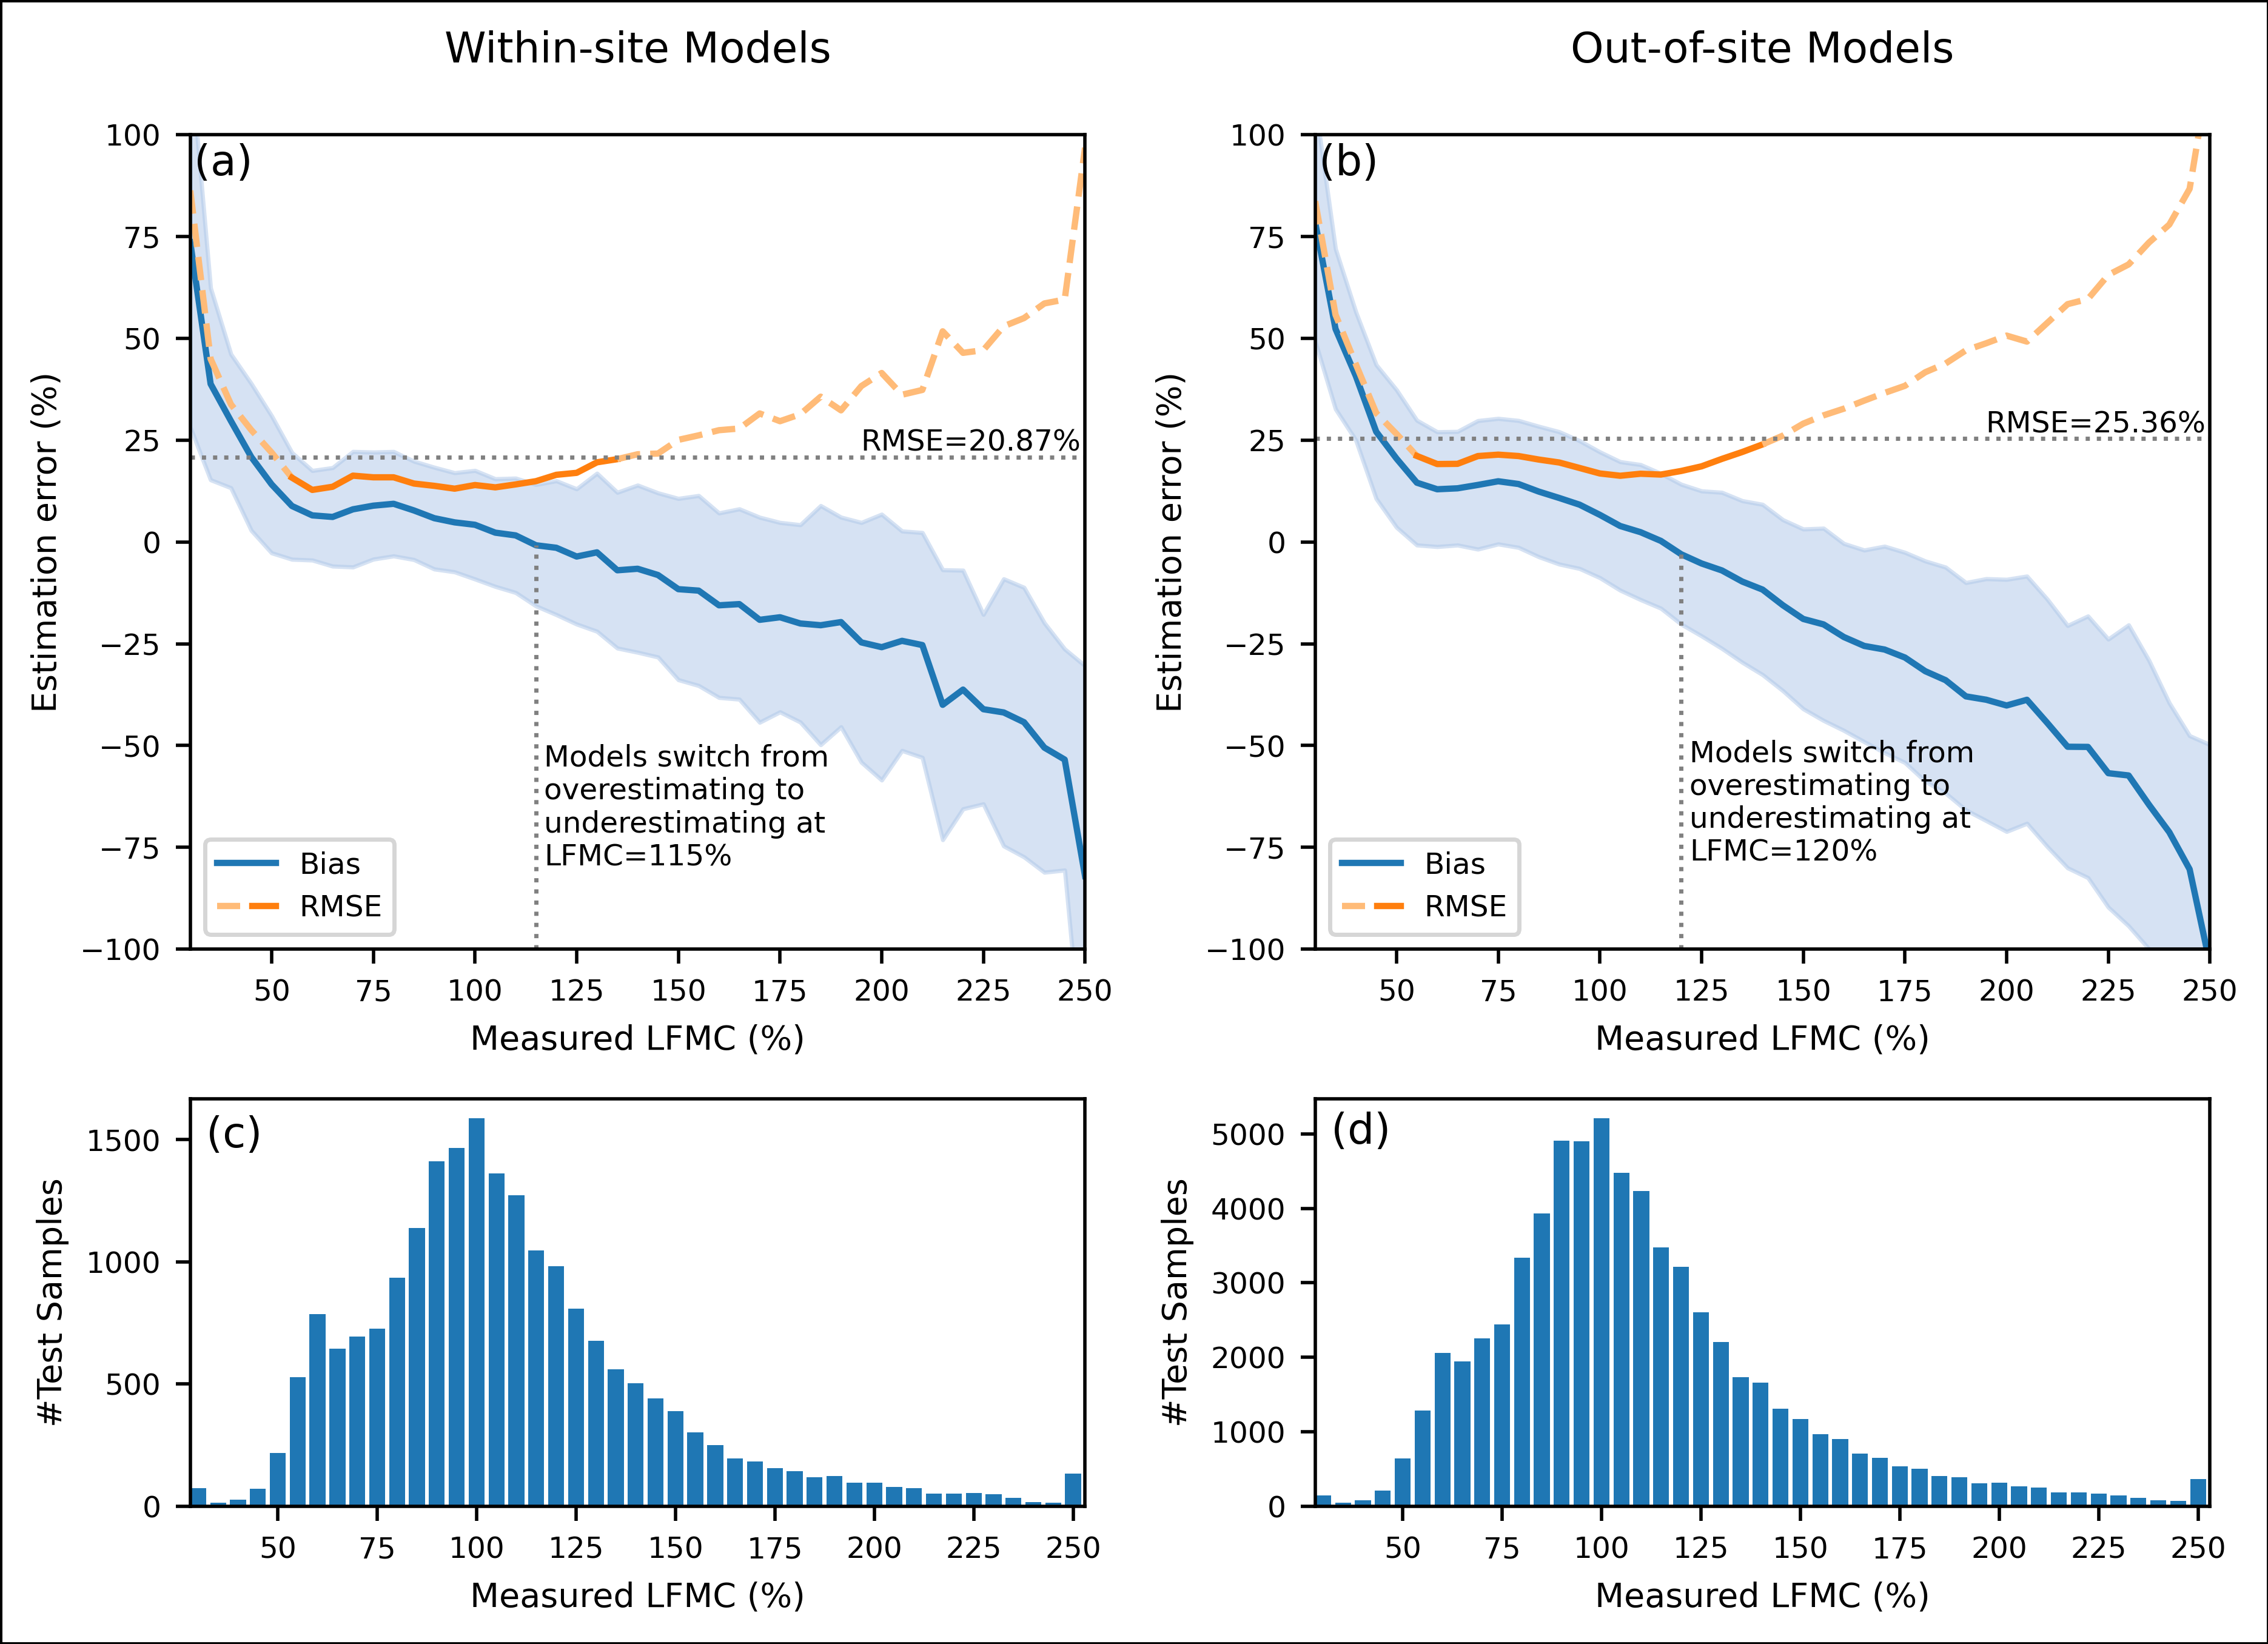

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(7.559, 5.5), dpi=500, gridspec_kw={'height_ratios': [2, 1]}, linewidth=1, edgecolor="black")

lower = 55
upper = 135
ax1 = plot_by_range(df1, ax1, [30, 250], xfocus=[lower, upper], yfocus=WITHIN_SITE_RMSE, width=BIN_SIZE)
ax1.set_title(f'{DISPLAY_NAMES[0]}\n', size=TITLE_SIZE)
ax1.text(31.0, 98.0, '(a)', va='top', fontsize=TITLE_SIZE)

lower = 55
upper = 140
ax2 = plot_by_range(df2, ax2, [30, 250], xfocus=[lower, upper], yfocus=OUT_OF_SITE_RMSE, width=BIN_SIZE)
ax2.set_title(f'{DISPLAY_NAMES[1]}\n', size=TITLE_SIZE)
ax2.text(31.0, 98.0, '(b)', va='top', fontsize=TITLE_SIZE)

ax3 = samples_by_range(df3, ax3, 30, 250, width=BIN_SIZE, clip=True, xlabel_start=4, xlabel_freq=5)
ax3.text(0.4, 1600.0, '(c)', va='top', fontsize=TITLE_SIZE)

ax4 = samples_by_range(df4, ax4, 30, 250, width=BIN_SIZE, clip=True, xlabel_start=4, xlabel_freq=5)
ax4.text(0.4, 5300.0, '(d)', va='top', fontsize=TITLE_SIZE)

fig.tight_layout(pad=1)
fig.savefig(os.path.join(output_dir, 'LFMC range1.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.1, dpi=500)

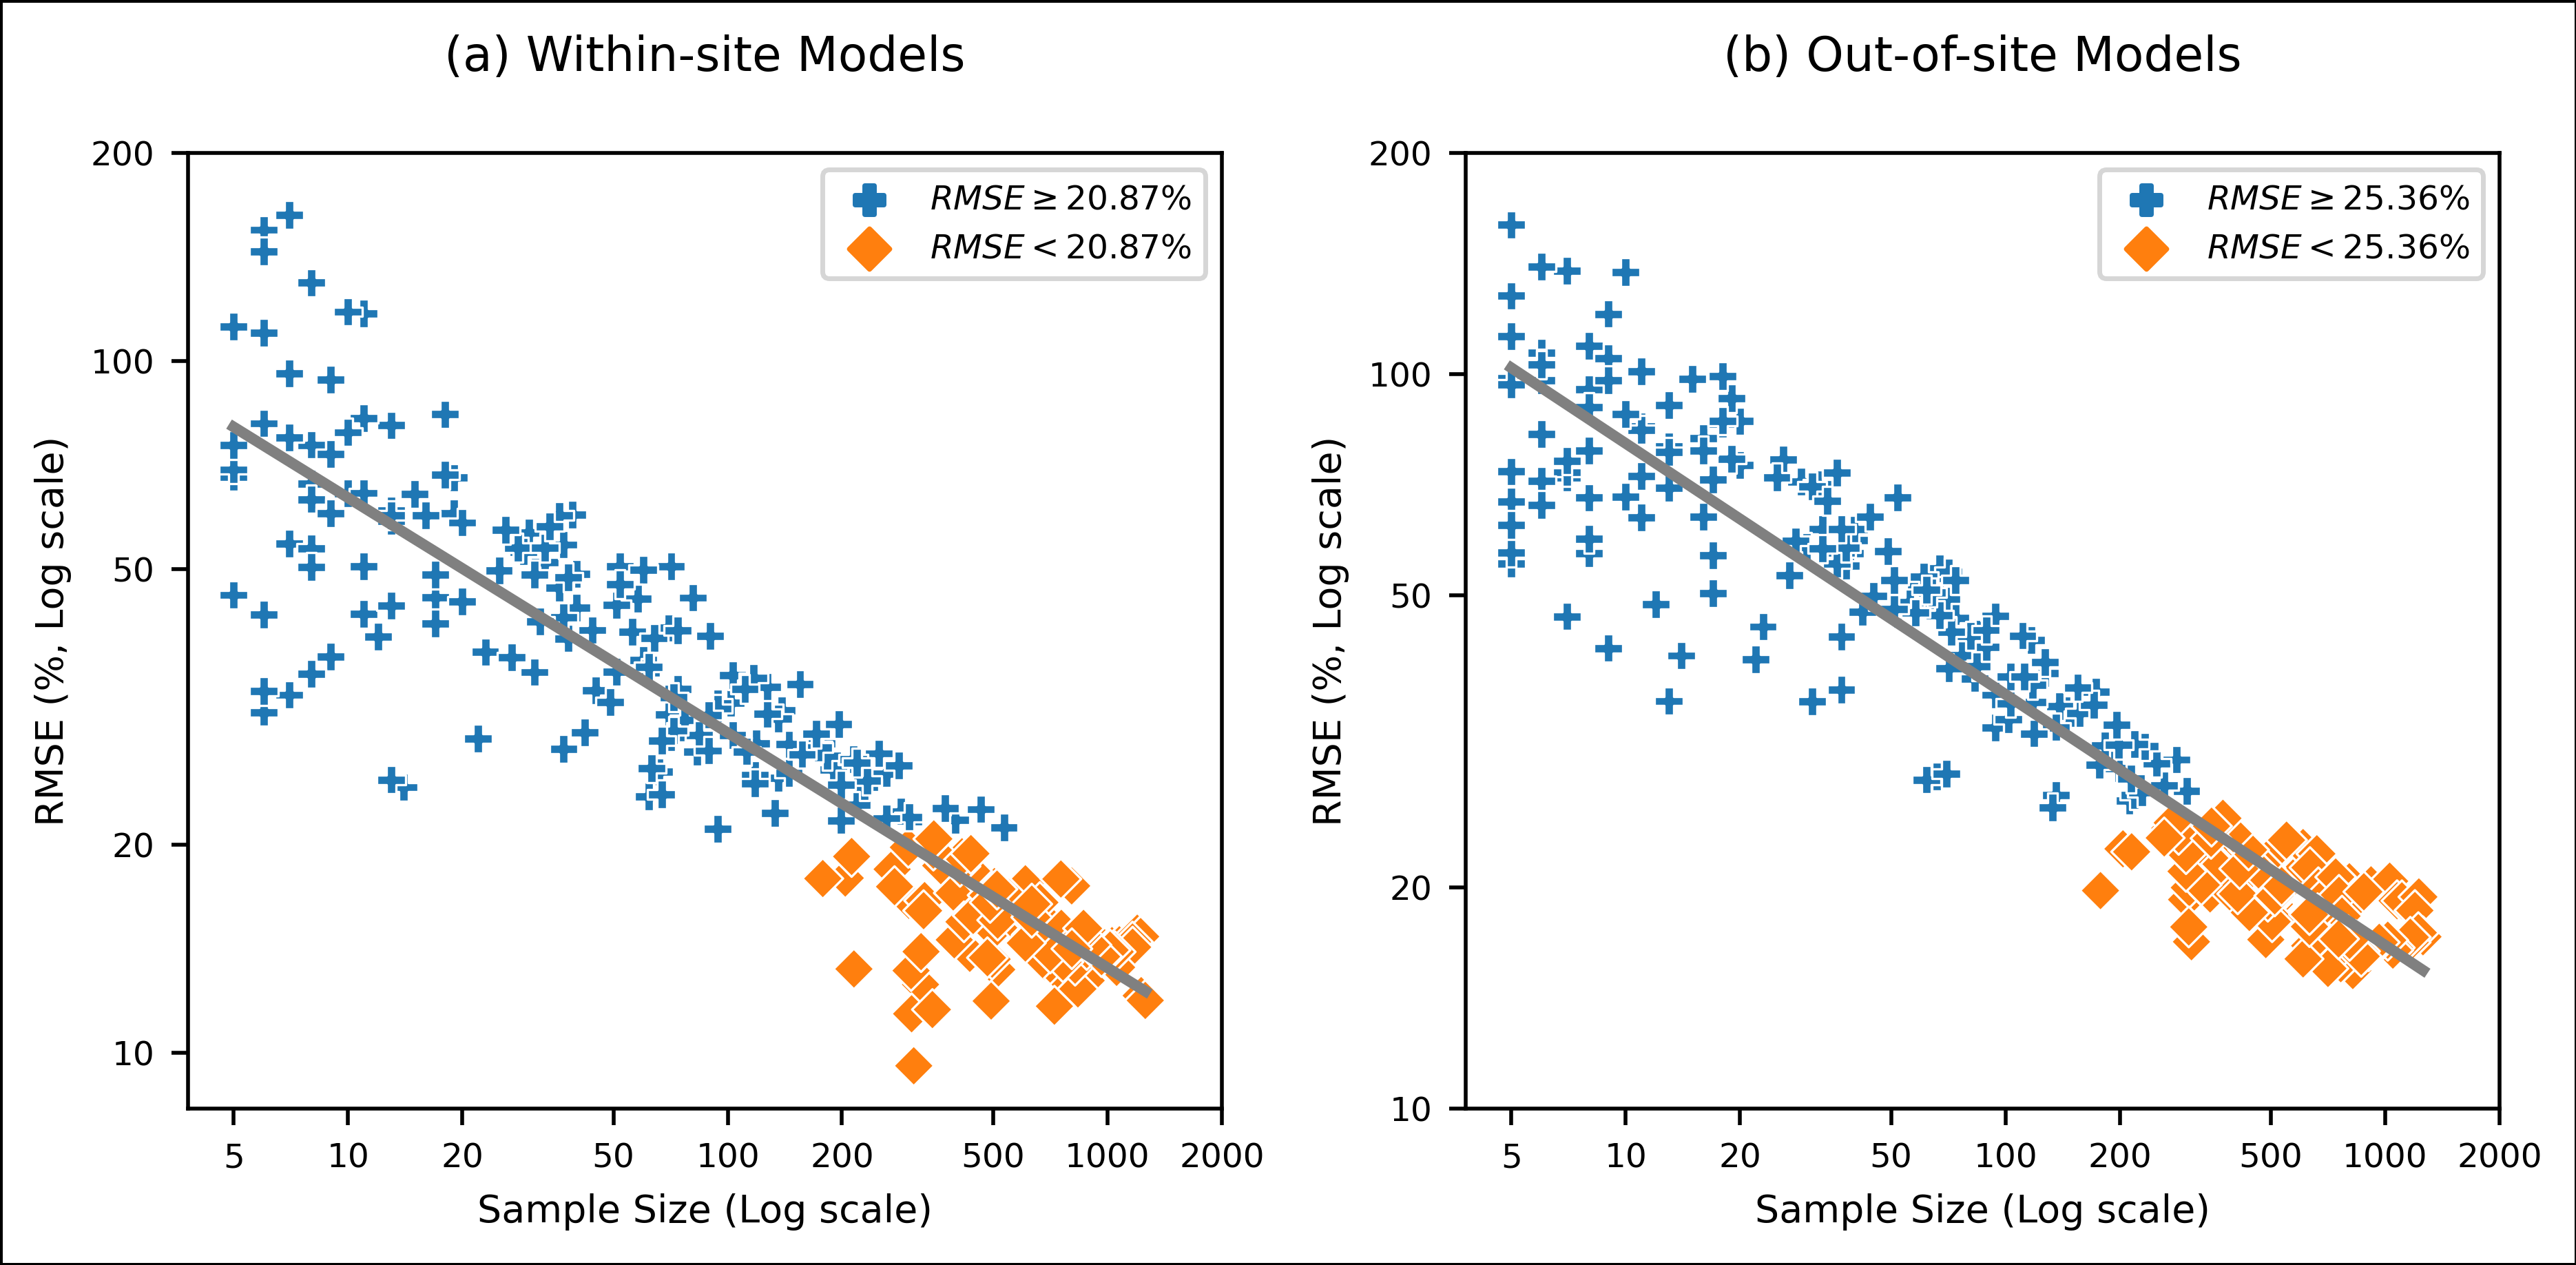

In [19]:
fig, ((ax5, ax6)) = plt.subplots(1, 2, figsize=(7.559, 3.75), dpi=500, linewidth=1, edgecolor="black")

ax5 = gen_scatterplot(x=rmse_df['Count'], y=rmse_df['Year-RMSE'], ax=ax5, xlabels=xlabels, ylabels=ylabels, threshold=WITHIN_SITE_RMSE)
ax5.set_title(f'(a) {DISPLAY_NAMES[0]}\n', size=TITLE_SIZE)
#ax5.text(0.6, 1.025, '(a)', va='top', fontsize=TITLE_SIZE)

ax6 = gen_scatterplot(x=rmse_df['Count'], y=rmse_df['Site-RMSE'], ax=ax6, xlabels=xlabels, ylabels=ylabels, threshold=OUT_OF_SITE_RMSE)
ax6.set_title(f'(b) {DISPLAY_NAMES[1]}\n', size=TITLE_SIZE)
#ax6.text(0.6, 1.025, '(b)', va='bottom', fontsize=TITLE_SIZE)

fig.tight_layout(pad=1)
fig.savefig(os.path.join(output_dir, 'LFMC range2.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.1, dpi=500)